In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import hamming_loss, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import re

In [7]:
raw_memory_data_set = pd.read_csv('memory_components.csv')
memory_subset = raw_memory_data_set[['component_name','Speed','CAS_Latency', 'First_Word_Latency', 'Form_Factor', 'Heat_Spreader', 'Manufacturer', 'Modules', 'Voltage','component_link']].copy()

# Function to clean memory speed (removes DDR4-/DDR5- and converts to numeric)
def clean_speed(value):
    try:
        cleaned = str(value).strip()
        # Remove DDR4- or DDR5- prefix using regex
        cleaned = cleaned.replace('DDR4-', '').replace('DDR5-', '').replace('DDR3-', '')
        float_val = float(cleaned)
        if float_val.is_integer():
            return int(float_val)  # Convert to int64 for whole MHz values
        else:
            print(f"Warning: Non-integer speed value '{value}' (cleaned: {cleaned}), replacing with 0")
            return 0
    except (ValueError, TypeError):
        print(f"Warning: Invalid speed value '{value}', replacing with 0")
        return 0

    
# Convert First_Word_Latency to float (remove 'ns')
memory_subset['First_Word_Latency'] = memory_subset['First_Word_Latency'].str.replace(' ns', '').astype('float64')

# Extract DDR4 or DDR5 from Form_Factor
memory_subset['Form_Factor'] = memory_subset['Form_Factor'].apply(
    lambda x: re.search(r'DDR[4-5]', x).group(0) if re.search(r'DDR[4-5]', x) else x
)

# Convert Voltage to float (remove 'V')
memory_subset['Voltage'] = memory_subset['Voltage'].str.replace(' V', '').astype('float64')


memory_subset['Speed'] = memory_subset['Speed'].apply(clean_speed).astype('int64')
# Convert categorical columns to string type
for col in ['component_name','Form_Factor', 'Heat_Spreader', 'Manufacturer', 'Modules','component_link']:
    memory_subset[col] = memory_subset[col].astype('string')

# Verify the updated data types
print("Updated Memory Components Table Info:")
print(memory_subset.info())

# Display the first few rows
print("\nFirst few rows of updated table:")
print(memory_subset.head())


Updated Memory Components Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   component_name      554 non-null    string 
 1   Speed               554 non-null    int64  
 2   CAS_Latency         554 non-null    int64  
 3   First_Word_Latency  554 non-null    float64
 4   Form_Factor         554 non-null    string 
 5   Heat_Spreader       554 non-null    string 
 6   Manufacturer        554 non-null    string 
 7   Modules             554 non-null    string 
 8   Voltage             554 non-null    float64
 9   component_link      554 non-null    string 
dtypes: float64(2), int64(2), string(6)
memory usage: 43.4 KB
None

First few rows of updated table:
                                      component_name  Speed  CAS_Latency  \
0  G.Skill Trident Z5 RGB 32 GB (2 x 16 GB) DDR5-...   7200           34   
1  TEAMGROUP T-C

In [8]:
# Load dataset
raw_video_card_data_set = pd.read_csv('video_card_components.csv')

# Create subset
video_card_subset = raw_video_card_data_set[['component_name','Case_Expansion_Slot_Width', 'Chipset', 'Cooling', 'Core_Clock', 
                                            'DisplayPort_Outputs', 'External_Power', 'HDMI_Outputs', 
                                            'Interface', 'Length', 'Manufacturer', 'Memory', 
                                            'Memory_Type', 'TDP', 'Total_Slot_Width','component_link']].copy()

# Function to clean numeric columns
def clean_numeric(value, suffix):
    try:
        cleaned = str(value).strip()
        if cleaned.endswith(suffix):
            return float(cleaned.replace(suffix, ''))
        else:
            print(f"Warning: Invalid format for value '{value}', expected suffix '{suffix}', replacing with 0")
            return 0
    except (ValueError, TypeType):
        print(f"Warning: Invalid value '{value}', replacing with 0")
        return 0

# Function to clean Core_Clock
def clean_core_clock(value):
    try:
        cleaned = str(value).strip()
        if cleaned.endswith(' MHz'):
            cleaned = cleaned.replace(' MHz', '')
        elif cleaned.endswith(' GHz'):
            cleaned = float(cleaned.replace(' GHz', '')) * 1000
        float_val = float(cleaned)
        if float_val.is_integer():
            return int(float_val)
        else:
                      return 0
    except (ValueError, TypeError):
         return 0

# Apply cleaning
video_card_subset['Core_Clock'] = video_card_subset['Core_Clock'].apply(clean_core_clock).astype('int64')
video_card_subset['Length'] = video_card_subset['Length'].apply(lambda x: clean_numeric(x, ' mm')).astype('int64')
video_card_subset['Memory'] = video_card_subset['Memory'].apply(lambda x: clean_numeric(x, ' GB')).astype('int64')
video_card_subset['TDP'] = video_card_subset['TDP'].apply(lambda x: clean_numeric(x, ' W')).astype('int64')
video_card_subset['DisplayPort_Outputs'] = video_card_subset['DisplayPort_Outputs'].fillna(0).astype('int64')
video_card_subset['HDMI_Outputs'] = video_card_subset['HDMI_Outputs'].fillna(0).astype('int64')

# Convert categorical columns
for col in ['component_name','Chipset', 'Cooling', 'External_Power', 'Interface', 'Manufacturer', 'Memory_Type','component_link']:
    video_card_subset[col] = video_card_subset[col].astype('string').fillna('Unknown')

# Verify data types
print("\nUpdated Video Card Components Table Info:")
print(video_card_subset.info())

# Display first few rows
print("\nFirst few rows of updated table:")
print(video_card_subset.head())


Updated Video Card Components Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   component_name             897 non-null    string
 1   Case_Expansion_Slot_Width  897 non-null    int64 
 2   Chipset                    897 non-null    string
 3   Cooling                    897 non-null    string
 4   Core_Clock                 897 non-null    int64 
 5   DisplayPort_Outputs        897 non-null    int64 
 6   External_Power             897 non-null    string
 7   HDMI_Outputs               897 non-null    int64 
 8   Interface                  897 non-null    string
 9   Length                     897 non-null    int64 
 10  Manufacturer               897 non-null    string
 11  Memory                     897 non-null    int64 
 12  Memory_Type                897 non-null    string
 13  TDP                   

In [9]:
# Load dataset
raw_cpu_data_set = pd.read_csv('cpu_components.csv')

# Create subset with specified columns (explicit copy)
cpu_subset = raw_cpu_data_set[['component_name','Core_Count', 'Core_Family', 'ECC_Support', 'Includes_Cooler', 
                               'L2_Cache', 'L3_Cache', 'Lithography', 'Manufacturer', 
                               'Microarchitecture', 
                               'Performance_Core_Clock', 'Series', 'Simultaneous_Multithreading', 
                               'Socket', 'TDP', 'Thread_Count','component_link']].copy()

# Function to clean clock speeds (handles MHz and GHz)
def clean_clock(value):
    try:
        cleaned = str(value).strip()
        if cleaned.endswith(' MHz'):
            cleaned = cleaned.replace(' MHz', '')
        elif cleaned.endswith(' GHz'):
            cleaned = float(cleaned.replace(' GHz', '')) * 1000  # Convert GHz to MHz
        float_val = float(cleaned)
        if float_val.is_integer():
            return int(float_val)
        else:
            print(f"Warning: Non-integer clock value '{value}' (cleaned: {cleaned}), replacing with 0")
            return 0
    except (ValueError, TypeError):
        print(f"Warning: Invalid clock value '{value}', replacing with 0")
        return 0


# Function to clean boolean-like columns
def clean_boolean(value):
    try:
        cleaned = str(value).strip().lower()
        if cleaned in ['yes', 'true', 'yes: hyper-threading', 'y', 't', '1']:
            return True
        elif cleaned in ['no', 'false', 'n', 'f', '0']:
            return False
        else:
            print(f"Warning: Invalid boolean value '{value}', replacing with False")
            return False
    except (ValueError, TypeError):
        print(f"Warning: Invalid boolean value '{value}', replacing with False")
        return False


# Clean and convert numeric columns
cpu_subset['Core_Count'] = cpu_subset['Core_Count'].fillna(0).astype('int64')
cpu_subset['Thread_Count'] = cpu_subset['Thread_Count'].fillna(0).astype('int64')
cpu_subset['L2_Cache'] = cpu_subset['L2_Cache'].apply(lambda x: clean_numeric(x, ' MB')).astype('int64')
cpu_subset['L3_Cache'] = cpu_subset['L3_Cache'].apply(lambda x: clean_numeric(x, ' MB')).astype('int64')
cpu_subset['Lithography'] = cpu_subset['Lithography'].apply(lambda x: clean_numeric(x, ' nm')).astype('int64')
cpu_subset['Performance_Core_Clock'] = cpu_subset['Performance_Core_Clock'].apply(clean_clock).astype('int64')


# Function to clean numeric columns
def clean_numeric(value, suffix):
    try:
        cleaned = str(value).strip()
        if cleaned.endswith(suffix):
            return float(cleaned.replace(suffix, ''))
        else:
        
            return 0
    except (ValueError, TypeType):
    
        return 0

cpu_subset['TDP'] = cpu_subset['TDP'].apply(lambda x: clean_numeric(x, ' W')).astype('int64')



# Clean and convert boolean columns
cpu_subset['ECC_Support'] = cpu_subset['ECC_Support'].apply(clean_boolean).astype('bool')
cpu_subset['Includes_Cooler'] = cpu_subset['Includes_Cooler'].apply(clean_boolean).astype('bool')
cpu_subset['Simultaneous_Multithreading'] = cpu_subset['Simultaneous_Multithreading'].apply(clean_boolean).astype('bool')

# Convert categorical columns to string
for col in ['component_name','Core_Family', 'Manufacturer', 'Microarchitecture', 'Series', 'Socket','component_link']:
    cpu_subset[col] = cpu_subset[col].astype('string').fillna('Unknown')

# Verify updated data types
print("\nUpdated CPU Components Table Info:")
print(cpu_subset.info())

# Display first few rows
print("\nFirst few rows of updated table:")
print(cpu_subset.head())


Updated CPU Components Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   component_name               290 non-null    string
 1   Core_Count                   290 non-null    int64 
 2   Core_Family                  290 non-null    string
 3   ECC_Support                  290 non-null    bool  
 4   Includes_Cooler              290 non-null    bool  
 5   L2_Cache                     290 non-null    int64 
 6   L3_Cache                     290 non-null    int64 
 7   Lithography                  290 non-null    int64 
 8   Manufacturer                 290 non-null    string
 9   Microarchitecture            290 non-null    string
 10  Performance_Core_Clock       290 non-null    int64 
 11  Series                       290 non-null    string
 12  Simultaneous_Multithreading  290 non-null    bool  
 13 

In [10]:
import pandas as pd

# Load dataset
raw_motherboard_data_set = pd.read_csv('motherboard_components.csv', sep=',', encoding='utf-8')

# Create subset with specified columns (explicit copy)
motherboard_subset = raw_motherboard_data_set[['component_name', 'Chipset', 'Form_Factor', 'M.2_Slots', 
                                              'Manufacturer', 'Memory_Max', 'Memory_Slots', 'Memory_Speed', 
                                              'Memory_Type', 'PCIe_x16_Slots', 'RAID_Support', 
                                              'SATA_6.0_Gb_s_Ports', 'Socket_CPU','component_link']].copy()

# Function to clean boolean-like columns
def clean_boolean(value):
    try:
        cleaned = str(value).strip().lower()
        if cleaned in ['yes', 'true', 'y', 't', '1']:
            return True
        elif cleaned in ['no', 'false', 'n', 'f', '0']:
            return False
        else:
            print(f"Warning: Invalid boolean value '{value}', replacing with False")
            return False
    except (ValueError, TypeError):
        print(f"Warning: Invalid boolean value '{value}', replacing with False")
        return False

# Function to clean M.2_Slots (count number of slots)
def clean_m2_slots(value):
    try:
        cleaned = str(value).strip()
        if cleaned == '' or cleaned.lower() == 'nan':
            return 0
        # Count slots by splitting on semicolons
        slot_count = len(cleaned.split(';'))
        return slot_count
    except (ValueError, TypeError):
        print(f"Warning: Invalid M.2_Slots value '{value}', replacing with 0")
        return 0

# Function to clean Memory_Speed (extract maximum speed)
def clean_memory_speed(value):
    try:
        cleaned = str(value).strip()
        if cleaned == '' or cleaned.lower() == 'nan':
            return 0
        # Split multiple speeds and remove DDR4-/DDR5- prefixes
        speeds = [s.strip().replace('DDR4-', '').replace('DDR5-', '') for s in cleaned.split(';')]
        # Convert to integers and take the maximum
        speeds = [int(float(s)) for s in speeds if s]
        return max(speeds) if speeds else 0
    except (ValueError, TypeError):
        print(f"Warning: Invalid Memory_Speed value '{value}', replacing with 0")
        return 0

# Clean and convert numeric columns
motherboard_subset['M.2_Slots'] = motherboard_subset['M.2_Slots'].apply(clean_m2_slots).astype('int64')
motherboard_subset['Memory_Slots'] = motherboard_subset['Memory_Slots'].fillna(0).astype('int64')
motherboard_subset['PCIe_x16_Slots'] = motherboard_subset['PCIe_x16_Slots'].fillna(0).astype('int64')
motherboard_subset['SATA_6.0_Gb_s_Ports'] = motherboard_subset['SATA_6.0_Gb_s_Ports'].fillna(0).astype('int64')
motherboard_subset['Memory_Max'] = motherboard_subset['Memory_Max'].apply(lambda x: clean_numeric(x, ' GB')).astype('int64')
motherboard_subset['Memory_Speed'] = motherboard_subset['Memory_Speed'].apply(clean_memory_speed).astype('int64')

# Clean and convert boolean column
motherboard_subset['RAID_Support'] = motherboard_subset['RAID_Support'].apply(clean_boolean).astype('bool')

# Convert categorical columns to string
for col in ['component_name', 'Chipset', 'Form_Factor', 'Manufacturer', 'Memory_Type', 'Socket_CPU','component_link']:
    motherboard_subset[col] = motherboard_subset[col].astype('string').fillna('Unknown')

# Verify updated data types
print("\nUpdated Motherboard Components Table Info:")
print(motherboard_subset.info())

# Display first few rows
print("\nFirst few rows of updated table:")
print(motherboard_subset.head())


Updated Motherboard Components Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   component_name       839 non-null    string
 1   Chipset              839 non-null    string
 2   Form_Factor          839 non-null    string
 3   M.2_Slots            839 non-null    int64 
 4   Manufacturer         839 non-null    string
 5   Memory_Max           839 non-null    int64 
 6   Memory_Slots         839 non-null    int64 
 7   Memory_Speed         839 non-null    int64 
 8   Memory_Type          839 non-null    string
 9   PCIe_x16_Slots       839 non-null    int64 
 10  RAID_Support         839 non-null    bool  
 11  SATA_6.0_Gb_s_Ports  839 non-null    int64 
 12  Socket_CPU           839 non-null    string
 13  component_link       839 non-null    string
dtypes: bool(1), int64(6), string(7)
memory usage: 86.2 KB
None

Fi

In [11]:

# Load dataset
raw_power_supply_data_set = pd.read_csv('power_supply_components.csv', on_bad_lines='skip', sep=',', encoding='utf-8')

# Create subset with specified columns (explicit copy)
power_supply_subset = raw_power_supply_data_set[['component_name', 'AMP_Molex_4pin_Connectors', 'EPS_8pin_Connectors', 
                                                'Efficiency_Rating', 'Length', 'Manufacturer', 'Modular', 
                                                'PCIe_12pin_Connectors', 'PCIe_16pin_12VHPWR_12V2x6_Connectors', 
                                                'PCIe_62pin_Connectors', 'PCIe_6pin_Connectors', 'PCIe_8pin_Connectors', 
                                                'SATA_Connectors', 'Type', 'Wattage','component_link']].copy()


# Function to clean modular column (handles multiple modular types)
def clean_modular(value):
    try:
        cleaned = str(value).strip().lower()
        if cleaned in ['fully modular', 'full', 'yes', 'true', 'y', 't', '1']:
            return 'Fully Modular'
        elif cleaned in ['semi modular', 'semi']:
            return 'Semi Modular'
        elif cleaned in ['non modular', 'no', 'false', 'n', 'f', '0']:
            return 'Non Modular'
        else:
          
            return 'Unknown'
    except (ValueError, TypeError):

        return 'Unknown'


# Clean and convert numeric columns
power_supply_subset['AMP_Molex_4pin_Connectors'] = power_supply_subset['AMP_Molex_4pin_Connectors'].fillna(0).astype('int64')
power_supply_subset['EPS_8pin_Connectors'] = power_supply_subset['EPS_8pin_Connectors'].fillna(0).astype('int64')
power_supply_subset['PCIe_12pin_Connectors'] = power_supply_subset['PCIe_12pin_Connectors'].fillna(0).astype('int64')
power_supply_subset['PCIe_16pin_12VHPWR_12V2x6_Connectors'] = power_supply_subset['PCIe_16pin_12VHPWR_12V2x6_Connectors'].fillna(0).astype('int64')
power_supply_subset['PCIe_62pin_Connectors'] = power_supply_subset['PCIe_62pin_Connectors'].fillna(0).astype('int64')
power_supply_subset['PCIe_6pin_Connectors'] = power_supply_subset['PCIe_6pin_Connectors'].fillna(0).astype('int64')
power_supply_subset['PCIe_8pin_Connectors'] = power_supply_subset['PCIe_8pin_Connectors'].fillna(0).astype('int64')
power_supply_subset['SATA_Connectors'] = power_supply_subset['SATA_Connectors'].fillna(0).astype('int64')
power_supply_subset['Length'] = power_supply_subset['Length'].apply(lambda x: clean_numeric(x, ' mm')).astype('int64')
power_supply_subset['Wattage'] = power_supply_subset['Wattage'].apply(lambda x: clean_numeric(x, ' W')).astype('int64')

# Clean and convert Modular column
power_supply_subset['Modular'] = power_supply_subset['Modular'].apply(clean_modular).astype('string')

# Convert categorical columns to string
for col in ['component_name', 'Efficiency_Rating', 'Manufacturer', 'Type','component_link']:
    power_supply_subset[col] = power_supply_subset[col].astype('string').fillna('Unknown')

# Verify updated data types
print("\nUpdated Power Supply Components Table Info:")
print(power_supply_subset.info())

# Display first few rows
print("\nFirst few rows of updated table:")
print(power_supply_subset.head())


Updated Power Supply Components Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   component_name                        311 non-null    string
 1   AMP_Molex_4pin_Connectors             311 non-null    int64 
 2   EPS_8pin_Connectors                   311 non-null    int64 
 3   Efficiency_Rating                     311 non-null    string
 4   Length                                311 non-null    int64 
 5   Manufacturer                          311 non-null    string
 6   Modular                               311 non-null    string
 7   PCIe_12pin_Connectors                 311 non-null    int64 
 8   PCIe_16pin_12VHPWR_12V2x6_Connectors  311 non-null    int64 
 9   PCIe_62pin_Connectors                 311 non-null    int64 
 10  PCIe_6pin_Connectors                  311 non-null   

In [13]:

# Load dataset
raw_storage_components_data_set = pd.read_csv('storage_components.csv',  sep=',', encoding='utf-8')

# Create subset with specified columns (explicit copy)
storage_subset = raw_storage_components_data_set[['component_name', 'Capacity', 'Form_Factor', 'Interface', 
                                                 'Manufacturer', 'NVME', 'Type','component_link']].copy()

# Function to clean numeric columns with units (e.g., GB, TB)
def clean_capacity(value):
    try:
        cleaned = str(value).strip().upper()
        if cleaned.endswith(' TB'):
            return int(float(cleaned.replace(' TB', '')) * 1000)  # Convert TB to GB
        elif cleaned.endswith(' GB'):
            return int(float(cleaned.replace(' GB', '')))
        else:
            return 0
    except (ValueError, TypeError):
  
        return 0

# Function to clean boolean-like columns (for NVME)
def clean_boolean(value):
    try:
        cleaned = str(value).strip().lower()
        if cleaned in ['yes', 'true', 'y', 't', '1', 'nvme']:
            return True
        elif cleaned in ['no', 'false', 'n', 'f', '0', 'sata']:
            return False
        else:
            print(f"Warning: Invalid NVME value '{value}', replacing with False")
            return False
    except (ValueError, TypeError):
        return False

# Print unique values for key columns before cleaning
print("Unique Capacity values before cleaning:")
print(storage_subset['Capacity'].value_counts(dropna=False))
print("\nUnique NVME values before cleaning:")
print(storage_subset['NVME'].value_counts(dropna=False))
print("\nUnique Form_Factor values before cleaning:")
print(storage_subset['Form_Factor'].value_counts(dropna=False))

# Clean and convert columns
storage_subset['Capacity'] = storage_subset['Capacity'].apply(clean_capacity).astype('int64')
storage_subset['NVME'] = storage_subset['NVME'].apply(clean_boolean).astype('bool')

# Convert categorical columns to string
for col in ['component_name', 'Form_Factor', 'Interface', 'Manufacturer', 'Type','component_link']:
    storage_subset[col] = storage_subset[col].astype('string').fillna('Unknown')

# Verify updated data types
print("\nUpdated Storage Components Table Info:")
print(storage_subset.info())

# Display first few rows
print("\nFirst few rows of updated table:")
print(storage_subset.head())

Unique Capacity values before cleaning:
Capacity
1 TB        230
2 TB        211
500 GB       70
4 TB         37
512 GB       21
240 GB       15
NaN          15
250 GB       10
256 GB       10
480 GB        8
128 GB        6
2.048 TB      5
960 GB        5
120 GB        4
1.02 TB       3
275 GB        3
1.024 TB      2
8 TB          2
525 GB        2
4.096 TB      1
118 GB        1
1.5 TB        1
320 GB        1
Name: count, dtype: int64

Unique NVME values before cleaning:
NVME
Yes    521
No     127
NaN     15
Name: count, dtype: int64

Unique Form_Factor values before cleaning:
Form_Factor
M.2-2280    531
2.5"        110
NaN          15
3.5"          7
Name: count, dtype: int64

Updated Storage Components Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   component_name  663 non-null    string
 1   Capacity        663 non-null 

In [3]:

# Load dataset
raw_case_components_data_set = pd.read_csv('case_components.csv', sep=',', encoding='utf-8')

# Create subset with specified columns (explicit copy)
case_subset = raw_case_components_data_set[['component_name', 'Dimensions', 'Expansion_Slots', 
                                           'Maximum_Video_Card_Length', 'Motherboard_Form_Factor', 
                                           'Power_Supply_Shroud', 'Type', 'Volume','component_link']].copy()

# Function to clean numeric values
def clean_numeric(value, suffix: str) -> str:
    if pd.isna(value) or str(value).strip().lower() == 'nan':
        return '0'
    value = str(value).strip()
    # Match number (integer or float) followed by suffix, ignoring trailing text
    pattern = rf'^(\d+\.?\d*)\s*{re.escape(suffix)}\b.*$'
    match = re.match(pattern, value)
    if match:
        return str(int(float(match.group(1))))  # Convert to int to remove decimals
    # Handle cases without suffix (e.g., '455')
    if value.replace('.', '').isdigit():
        return str(int(float(value)))
    print(f"Warning: Invalid format for value '{value}', expected suffix '{suffix}', replacing with 0")
    return '0'

# Function to clean boolean values
def clean_boolean(value):
    if pd.isna(value):
        return False
    value = str(value).strip().lower()
    return value in ['yes', 'true', 'y', '1']

# Function to clean expansion slots
def clean_expansion_slots(value):
    if pd.isna(value):
        return 0
    match = re.match(r'(\d+)', str(value))
    return int(match.group(1)) if match else 0

# Function to clean dimensions
def clean_dimensions(dim_str):
    if pd.isna(dim_str) or str(dim_str).lower() == 'nan':
        return (0, 0, 0)
    mm_part = str(dim_str).split(';')[0].strip()
    match = re.match(r'(\d+\.?\d*)\s*mm\s*x\s*(\d+\.?\d*)\s*mm\s*x\s*(\d+\.?\d*)\s*mm', mm_part)
    if match:
        return tuple(float(x) for x in match.groups())
    return (0, 0, 0)


# Function to clean Motherboard_Form_Factor
def clean_motherboard_form_factor(value):
    if pd.isna(value):
        return 'Unknown'
    value = str(value).strip()
    # Split on semicolons or commas, clean up whitespace
    form_factors = [f.strip() for f in re.split(r'[;,]', value)]
    # Standardize common form factors (optional)
    valid_factors = {'ATX', 'EATX', 'Micro ATX', 'Mini ITX', 'Mini-ITX', 'ITX', 'mATX', 'Micro-ATX'}
    cleaned_factors = [f for f in form_factors if f in valid_factors or f.lower() in {v.lower() for v in valid_factors}]
    # Return as semicolon-separated string
    return '; '.join(cleaned_factors) if cleaned_factors else 'Unknown'


# Clean and convert Dimensions
case_subset[['Height_mm', 'Width_mm', 'Depth_mm']] = pd.DataFrame(
    case_subset['Dimensions'].apply(clean_dimensions).tolist(), index=case_subset.index
)
case_subset = case_subset.drop(columns=['Dimensions'])


# Clean and convert other columns
case_subset['Expansion_Slots'] = case_subset['Expansion_Slots'].apply(clean_expansion_slots).astype('int64')
case_subset['Maximum_Video_Card_Length'] = case_subset['Maximum_Video_Card_Length'].apply(
    lambda x: clean_numeric(x, ' mm')
).astype('int64')
case_subset['Volume'] = case_subset['Volume'].apply(
    lambda x: clean_numeric(x, ' L')
).astype('float64')
case_subset['Power_Supply_Shroud'] = case_subset['Power_Supply_Shroud'].apply(clean_boolean).astype('bool')



case_subset['Motherboard_Form_Factor'] = case_subset['Motherboard_Form_Factor'].apply(clean_motherboard_form_factor).astype('string')
form_factor_dummies = case_subset['Motherboard_Form_Factor'].str.get_dummies('; ')
case_subset = pd.concat([case_subset, form_factor_dummies], axis=1)
case_subset = case_subset.drop(columns=['Motherboard_Form_Factor'])
# Convert categorical columns to string
for col in ['component_name', 'Type','component_link']:
    case_subset[col] = case_subset[col].astype('string').fillna('Unknown')

# Verify updated data types
print("\nUpdated Case Components Table Info:")
print(case_subset.info())

# Display first few rows
print("\nFirst few rows of updated table:")
print(case_subset.head())

NameError: name 'pd' is not defined

In [9]:
import pandas as pd
import re

# Load dataset
raw_cpu_cooler_data_set = pd.read_csv('cpu_cooler_components.csv', sep=',', encoding='utf-8')

# Create subset with specified columns (explicit copy)
cpu_cooler_subset = raw_cpu_cooler_data_set[['component_name', 'CPU_Socket', 'Fan_RPM', 'Manufacturer', 'Noise_Level', 'Water_Cooled','component_link']].copy()

# Function to clean numeric values with suffix (e.g., '1200 RPM', '25 dB', '14.8 - 23.6 dB')
def clean_numeric(value, suffix: str) -> str:
    if pd.isna(value) or str(value).strip().lower() == 'nan':
        return '0'
    value = str(value).strip()
    # Match range (e.g., '14.8 - 23.6 dB') or single value (e.g., '25 dB')
    range_pattern = rf'^(\d+\.?\d*)\s*-\s*(\d+\.?\d*)\s*{re.escape(suffix)}\b.*$'
    single_pattern = rf'^(\d+\.?\d*)\s*{re.escape(suffix)}\b.*$'
    
    # Check for range first
    range_match = re.match(range_pattern, value)
    if range_match:
        low, high = float(range_match.group(1)), float(range_match.group(2))
        return str((low + high) / 2)  # Return average of range
    
    # Check for single value
    single_match = re.match(single_pattern, value)
    if single_match:
        return str(float(single_match.group(1)))  # Return single value
    
    # Handle cases without suffix (e.g., '25')
    if value.replace('.', '').isdigit():
        return str(float(value))
    
    print(f"Warning: Invalid format for value '{value}', expected suffix '{suffix}' or range, replacing with 0")
    return '0'

# Function to clean water-cooled values and extract radiator size
def clean_water_cooled(value):
    if pd.isna(value) or str(value).strip().lower() == 'nan':
        return False, '0'
    value = str(value).strip()
    # Match patterns like 'Yes - 240 mm' or 'No'
    pattern = r'^(Yes|No)\s*(?:-\s*(\d+\.?\d*)\s*mm)?$'
    match = re.match(pattern, value, re.IGNORECASE)
    if match:
        is_water_cooled = match.group(1).lower() == 'yes'
        radiator_size = match.group(2) if match.group(2) else '0'
        return is_water_cooled, radiator_size
    print(f"Warning: Invalid Water_Cooled format '{value}', expected 'Yes - X mm' or 'No', replacing with False, 0")
    return False, '0'

# Function to clean CPU_Socket
def clean_cpu_socket(value):
    if pd.isna(value):
        return 'Unknown'
    value = str(value).strip()
    # Split on semicolons or commas, clean up whitespace
    sockets = [s.strip() for s in re.split(r'[;,]', value)]
    # Standardize common CPU sockets (optional, add more as needed)
    valid_sockets = {'AM4', 'AM5', 'LGA1700', 'LGA1200', 'LGA1151', 'TR4', 'sTRX4', 'FM2', 'AM3'}
    cleaned_sockets = [s for s in sockets if s in valid_sockets or s.lower() in {v.lower() for v in valid_sockets}]
    # Return as semicolon-separated string
    return '; '.join(cleaned_sockets) if cleaned_sockets else 'Unknown'

# Function to clean Fan_RPM (handle ranges or single values)
def clean_fan_rpm(value):
    if pd.isna(value):
        return 0
    value = str(value).strip()
    # Handle ranges like "800 - 2000 RPM" or single values like "1200 RPM"
    match = re.match(r'(\d+)(?:\s*-\s*(\d+))?\s*RPM\b', value)
    if match:
        # If range, take average; if single value, use it
        if match.group(2):
            low, high = float(match.group(1)), float(match.group(2))
            return int((low + high) / 2)
        return int(float(match.group(1)))
    # Handle cases without suffix
    if value.replace('.', '').isdigit():
        return int(float(value))
    print(f"Warning: Invalid Fan_RPM format '{value}', expected 'RPM' or range, replacing with 0")
    return 0

# Clean and convert Water_Cooled and create Radiator_Size_mm
cpu_cooler_subset[['Water_Cooled', 'Radiator_Size_mm']] = pd.DataFrame(
    cpu_cooler_subset['Water_Cooled'].apply(clean_water_cooled).tolist(), index=cpu_cooler_subset.index
)

# Clean and convert other columns
cpu_cooler_subset['Fan_RPM'] = cpu_cooler_subset['Fan_RPM'].apply(clean_fan_rpm).astype('int64')
cpu_cooler_subset['Noise_Level'] = cpu_cooler_subset['Noise_Level'].apply(
    lambda x: clean_numeric(x, 'dB')
).astype('float64')
cpu_cooler_subset['Water_Cooled'] = cpu_cooler_subset['Water_Cooled'].astype('bool')
cpu_cooler_subset['Radiator_Size_mm'] = cpu_cooler_subset['Radiator_Size_mm'].astype('float64')
cpu_cooler_subset['CPU_Socket'] = cpu_cooler_subset['CPU_Socket'].apply(clean_cpu_socket).astype('string')

# Create dummy variables for CPU_Socket
socket_dummies = cpu_cooler_subset['CPU_Socket'].str.get_dummies('; ')
cpu_cooler_subset = pd.concat([cpu_cooler_subset, socket_dummies], axis=1)
cpu_cooler_subset = cpu_cooler_subset.drop(columns=['CPU_Socket'])

# Convert categorical columns to string
for col in ['component_name', 'Manufacturer','component_link']:
    cpu_cooler_subset[col] = cpu_cooler_subset[col].astype('string').fillna('Unknown')

# Verify updated data types
print("\nUpdated CPU Cooler Components Table Info:")
print(cpu_cooler_subset.info())

# Display first few rows
print("\nFirst few rows of updated table:")
print(cpu_cooler_subset.head())


Updated CPU Cooler Components Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   component_name    259 non-null    string 
 1   Fan_RPM           259 non-null    int64  
 2   Manufacturer      259 non-null    string 
 3   Noise_Level       259 non-null    float64
 4   Water_Cooled      259 non-null    bool   
 5   component_link    259 non-null    string 
 6   Radiator_Size_mm  259 non-null    float64
 7   AM3               259 non-null    int64  
 8   AM4               259 non-null    int64  
 9   AM5               259 non-null    int64  
 10  FM2               259 non-null    int64  
 11  LGA1151           259 non-null    int64  
 12  LGA1200           259 non-null    int64  
 13  LGA1700           259 non-null    int64  
 14  Unknown           259 non-null    int64  
 15  sTRX4             259 non-null    int64  
dtypes

In [29]:
import pandas as pd
import re

# Assuming all subsets (cpu_subset, cpu_cooler_subset, etc.) are already loaded as per your code
df_cleaned_filtered = pd.read_csv('BuildDataSet.csv')
# Define key columns for each component
component_columns = {
    'CPU': ['component_name', 'Core_Count', 'Performance_Core_Clock', 'Socket'],
    'CPU Cooler': ['component_name', 'Water_Cooled', 'Radiator_Size_mm', 'Noise_Level'],
    'Case': ['component_name', 'Type', 'Height_mm', 'Width_mm', 'Depth_mm', 'ATX', 'Mini ITX'],
    'Memory': ['component_name', 'Speed', 'Form_Factor', 'Modules'],
    'Motherboard': ['component_name', 'Chipset', 'Form_Factor', 'Memory_Speed'],
    'Power Supply': ['component_name', 'Wattage', 'Efficiency_Rating', 'Modular'],
    'Storage': ['component_name', 'Capacity', 'Form_Factor', 'NVME'],
    'Video Card': ['component_name', 'Chipset', 'Memory', 'TDP']
}

# Component subsets dictionary
component_subsets = {
    'CPU': cpu_subset,
    'CPU Cooler': cpu_cooler_subset,
    'Case': case_subset,
    'Memory': memory_subset,
    'Motherboard': motherboard_subset,
    'Power Supply': power_supply_subset,
    'Storage': storage_subset,
    'Video Card': video_card_subset
}

# Initialize an empty DataFrame for the final table
build_table = pd.DataFrame()

# Get unique build titles
build_titles = df_cleaned_filtered['Build Title'].unique()

# For each build, gather component details
for build in build_titles:
    build_data = df_cleaned_filtered[df_cleaned_filtered['Build Title'] == build].copy()
    build_row = {'Build Title': build}
    
    # For each component type
    for component_type, subset in component_subsets.items():
        # Filter build_data for this component
        component_data = build_data[build_data['Component'] == component_type]
        if not component_data.empty:
            # Merge with the corresponding subset on Link and component_link
            merged = component_data.merge(
                subset,
                left_on='Link',
                right_on='component_link',
                how='left'
            )
            # Add selected columns to build_row with prefix
            for col in component_columns[component_type]:
                col_name = f"{component_type}_{col}"
                if col in merged.columns:
                    build_row[col_name] = merged[col].iloc[0] if not merged[col].empty else None
                else:
                    build_row[col_name] = None
        else:
            # If component is missing, fill with None
            for col in component_columns[component_type]:
                col_name = f"{component_type}_{col}"
                build_row[col_name] = None
    
    # Append the build_row to build_table
    build_table = pd.concat([build_table, pd.DataFrame([build_row])], ignore_index=True)

# Reorder columns for clarity
ordered_columns = ['Build Title']
for component_type in component_columns:
    ordered_columns.extend([f"{component_type}_{col}" for col in component_columns[component_type]])

build_table = build_table[ordered_columns]

# Verify data types and handle any missing values
build_table = build_table.fillna('Unknown')  # Replace None with 'Unknown' for consistency

# Display the final table info
print("\nUnified Build Table Info:")
print(build_table.info())

# Display the final table
print("\nUnified Build Table:")
print(build_table)


Unified Build Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Build Title                     1100 non-null   object
 1   CPU_component_name              1100 non-null   object
 2   CPU_Core_Count                  1100 non-null   object
 3   CPU_Performance_Core_Clock      1100 non-null   object
 4   CPU_Socket                      1100 non-null   object
 5   CPU Cooler_component_name       1100 non-null   object
 6   CPU Cooler_Water_Cooled         1100 non-null   object
 7   CPU Cooler_Radiator_Size_mm     1100 non-null   object
 8   CPU Cooler_Noise_Level          1100 non-null   object
 9   Case_component_name             1100 non-null   object
 10  Case_Type                       1100 non-null   object
 11  Case_Height_mm                  1100 non-null   object
 12  Case_Width_mm        

In [31]:
df = pd.DataFrame(build_table)
df.to_csv("pc_builds.csv", index=False)

In [17]:
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
import joblib
import numpy as np
import warnings
import pandas as pd
import numpy as np
import joblib
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# Load and verify dataset
print("Loading BuildDataSet.csv...")
df_cleaned_filtered = pd.read_csv('BuildDataSet.csv')
print(f"Number of builds in BuildDataSet.csv: {len(df_cleaned_filtered['Build Title'].unique())}")
print(f"Total rows in dataset: {len(df_cleaned_filtered)}")

# Define component types
component_types = [
    'CPU', 'Case', 'Memory', 'Motherboard',
    'Power Supply', 'Storage', 'Video Card'
]

# Component subsets dictionary
component_subsets = {
    'CPU': cpu_subset,
    'Case': case_subset,
    'Memory': memory_subset,
    'Motherboard': motherboard_subset,
    'Power Supply': power_supply_subset,
    'Storage': storage_subset,
    'Video Card': video_card_subset
}

# Create missing components table
missing_components = []
build_titles = df_cleaned_filtered['Build Title'].unique()

for build in build_titles:
    build_data = df_cleaned_filtered[df_cleaned_filtered['Build Title'] == build].copy()
    for comp_type in component_types:
        component_data = build_data[build_data['Component'] == comp_type]
        if component_data.empty:
            missing_components.append({
                'Build Title': build,
                'Component': comp_type,
                'Product Name': 'Missing',
                'Link': 'No Link'
            })
        else:
            subset = component_subsets.get(comp_type)
            if subset is not None:
                merged = component_data.merge(
                    subset,
                    left_on='Link',
                    right_on='component_link',
                    how='left'
                )
                if merged['component_link'].isna().all():
                    link = component_data['Link'].iloc[0] if not component_data['Link'].empty else 'Invalid Link'
                    product_name = 'Unknown'
                    if not component_data['Link'].empty:
                        link_val = component_data['Link'].iloc[0]
                        subset_match = subset[subset['component_link'] == link_val]
                        if not subset_match.empty and 'component_name' in subset_match.columns:
                            product_name = subset_match['component_name'].iloc[0]
                    missing_components.append({
                        'Build Title': build,
                        'Component': comp_type,
                        'Product Name': product_name,
                        'Link': link
                    })

# Convert to DataFrame and save
missing_components_df = pd.DataFrame(missing_components)
missing_components_df.to_csv('missing_components_detailed.csv', index=False)
print(f"\nSaved missing components table to 'missing_components_detailed.csv'")
print(f"Missing components summary:\n{missing_components_df['Component'].value_counts()}")
print(f"Sample of missing components table (first 10 rows):\n{missing_components_df.head(10).to_string(index=False)}")

# Define key columns for each component
component_columns = {
    'CPU': ['Core_Count', 'Performance_Core_Clock'],
    'Case': ['Height_mm', 'Width_mm', 'Depth_mm', 'ATX', 'Mini ITX'],
    'Memory': ['Speed'],
    'Motherboard': ['Memory_Speed', 'M.2_Slots', 'Memory_Slots', 'PCIe_x16_Slots', 'SATA_6.0_Gb_s_Ports'],
    'Power Supply': ['Wattage'],
    'Storage': ['Capacity', 'NVME'],
    'Video Card': ['Memory', 'TDP']
}

# Create unified build table
build_table = pd.DataFrame()
missing_component_counts = {comp: 0 for comp in component_subsets}
missing_threshold = 0

dropped_builds = []
for build in build_titles:
    build_data = df_cleaned_filtered[df_cleaned_filtered['Build Title'] == build].copy()
    build_row = {'Build Title': build}
    missing_features = 0
    total_features = sum(len(cols) for cols in component_columns.values())
    
    for component_type in component_subsets:
        component_data = build_data[build_data['Component'] == component_type]
        if not component_data.empty:
            merged = component_data.merge(
                component_subsets[component_type],
                left_on='Link',
                right_on='component_link',
                how='left')
            if merged.empty or merged['component_link'].isna().all():
            
                missing_component_counts[component_type] += 1
                missing_features += len(component_columns[component_type])
            for col in component_columns[component_type]:
                col_name = f"{component_type}_{col}"
                if col in merged.columns and not merged[col].isna().all():
                    build_row[col_name] = merged[col].iloc[0]
                else:
                    build_row[col_name] = None
                    missing_features += 1
                
        else:
    
            missing_component_counts[component_type] += 1
            missing_features += len(component_columns[component_type])
            for col in component_columns[component_type]:
                build_row[f"{component_type}_{col}"] = None
    
    if missing_features / total_features <= missing_threshold:
        build_table = pd.concat([build_table, pd.DataFrame([build_row])], ignore_index=True)
    else:
        print(f"Skipping build: {build} (too many missing features: {missing_features}/{total_features})")
        dropped_builds.append(build)

        

# 2. Define Feature Columns
feature_columns = [
    'CPU_Core_Count',
    'CPU_Performance_Core_Clock',
    'Memory_Speed',
    'Video Card_Memory',
    'Power Supply_Wattage'
]



# 5. Build Pipeline with StandardScaler + Nearest Neighbors
recommender_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', NearestNeighbors(n_neighbors=5))
])

# 6. Fit Model
recommender_pipeline.fit(X)

# 7. Save the Model
joblib.dump(recommender_pipeline, "recommender_model_knn.pkl")

# 8. Example User Input
user_input = {
    'CPU_Core_Count': 6,
    'CPU_Performance_Core_Clock': 3.8,
    'Memory_Speed': 3200,
    'Video Card_Memory': 16,
    'Power Supply_Wattage': 650
}

# 9. Convert User Input to Feature Vector
user_vector = []
for col in feature_columns:
    user_vector.append(user_input.get(col, build_table[col].median()))
user_vector = np.array(user_vector).reshape(1, -1)

# 10. Predict Closest Builds
distances, indices = recommender_pipeline.named_steps['knn'].kneighbors(
    recommender_pipeline.named_steps['scaler'].transform(user_vector)
)

# 11. Output Recommendations
recommended_builds = build_table.iloc[indices[0]][['Build Title'] + feature_columns]

print("\n🎯 Top Recommended PC Builds Based on Your Specs:")
for i, row in recommended_builds.iterrows():
    print(f"- {row['Build Title']} | Specs: {row[feature_columns].to_dict()}")

Loading BuildDataSet.csv...
Number of builds in BuildDataSet.csv: 1100
Total rows in dataset: 10822

Saved missing components table to 'missing_components_detailed.csv'
Missing components summary:
Component
Power Supply    550
Case            122
Video Card       56
Motherboard      25
Memory           21
Storage          20
CPU               6
Name: count, dtype: int64
Sample of missing components table (first 10 rows):
                                              Build Title    Component Product Name                                                                                                                                Link
                             "cool boy B)" (second build) Power Supply      Unknown  https://pcpartpicker.com/product/fxGhP6/corsair-rm1000e-2023-1000-w-80-gold-certified-fully-modular-atx-power-supply-cp-9020264-na
                                   $1000 MINI BEAST Setup   Video Card      Missing                                                            

Skipping build: AMD 9070 XT Build (too many missing features: 2/18)
Skipping build: AMD Office PC and Minecraft Server (too many missing features: 4/18)
Skipping build: AMD Ryzen 5 7500F + Intel ARC A750 Build (too many missing features: 2/18)
Skipping build: AMD Ryzen 9 5950X Robust Work PC (too many missing features: 3/18)
Skipping build: AMD Ryzen 9 9900X + RTX 5080 👽 Build full ASUS TUF GAMING PC + Test 1080p 1440p 2160p (too many missing features: 2/18)
Skipping build: AMD Work Station Ryzen 7 9700X / Radeon RX 9070 (too many missing features: 4/18)
Skipping build: AMD's Nightmare (too many missing features: 2/18)
Skipping build: ASUS has been FRAME(4000)D (too many missing features: 2/18)
Skipping build: AYL final build 2024 (too many missing features: 2/18)
Skipping build: Aestethics Black $600 (too many missing features: 5/18)
Skipping build: Aircooling 2025 (too many missing features: 2/18)
Skipping build: Airflow fordays (too many missing features: 2/18)
Skipping build: Aleph

Skipping build: Finished Build MK.1 (too many missing features: 2/18)
Skipping build: First Budget White Build, for 1440p (too many missing features: 2/18)
Skipping build: First Build (2018 edition) (too many missing features: 2/18)
Skipping build: First Build - 13700kf, rx 7700xt (too many missing features: 2/18)
Skipping build: First Build - 9800x3d - RTX 5090 (too many missing features: 2/18)
Skipping build: First Build - Upgrade (too many missing features: 2/18)
Skipping build: First Build - White Prodigy m2022 (for sale) (too many missing features: 10/18)
Skipping build: First Build -9070xt (too many missing features: 2/18)
Skipping build: First Build I've done in nearly 20 years. (No RGB) (too many missing features: 2/18)
Skipping build: First Build White/Black 1440p Gaming + Productivity (too many missing features: 2/18)
Skipping build: First Build in 2018 & The Progression Until Now (too many missing features: 2/18)
Skipping build: First Ever Build 2017 (too many missing featur

Skipping build: Ironman (too many missing features: 2/18)
Skipping build: Itza PC (too many missing features: 2/18)
Skipping build: Jade Toaster (too many missing features: 2/18)
Skipping build: Jason's Build (too many missing features: 2/18)
Skipping build: Jeffs PC (too many missing features: 12/18)
Skipping build: Jonsbo D32 with 7800X3D and 5070 TI (too many missing features: 2/18)
Skipping build: Jonsbo TK1 case swap for the Mrs. (too many missing features: 3/18)
Skipping build: Jonsbo z20 Black (too many missing features: 7/18)
Skipping build: JoyBoy (too many missing features: 2/18)
Skipping build: Kabocha (too many missing features: 4/18)
Skipping build: King 95 Ultra Build (too many missing features: 7/18)
Skipping build: Kulantai’s Pc (too many missing features: 2/18)
Skipping build: Kyles Epic Gaming PC🔥[1440p BEAST]🔥 (too many missing features: 2/18)
Skipping build: LAVR: Tower 600, 5090, 9800x3D for VR Flight Sims (too many missing features: 2/18)
Skipping build: LIAN LI O

Skipping build: My personal build (too many missing features: 2/18)
Skipping build: NCASE M2 Round (too many missing features: 5/18)
Skipping build: NCASE M2 Round Black (too many missing features: 5/18)
Skipping build: NCC-1701-D (2016) (too many missing features: 2/18)
Skipping build: NR200 Station 1.0 (too many missing features: 2/18)
Skipping build: NR200 white v1 with ASUS TUF 4090 OG-OC (too many missing features: 7/18)
Skipping build: NZXT H5 RGB 9800X3D Nitro+ 9070 XT (too many missing features: 2/18)
Skipping build: NZXT-H6-FLOW BUILD (too many missing features: 2/18)
Skipping build: Naomi's Main Rig (too many missing features: 2/18)
Skipping build: Ncase T1 Portable Gaming Console (too many missing features: 5/18)
Skipping build: Neon City 2049 (too many missing features: 2/18)
Skipping build: New AMD 7800X3D (too many missing features: 2/18)
Skipping build: New And Improved (too many missing features: 2/18)
Skipping build: New Box 2025 (too many missing features: 2/18)
Skipp

Skipping build: Takachouten (Falcon Vertex) (too many missing features: 2/18)
Skipping build: Terminal 2 (My first actual PC Build) (too many missing features: 4/18)
Skipping build: Terminator (too many missing features: 1/18)
Skipping build: Terra PC (too many missing features: 2/18)
Skipping build: Terraform Fractor (too many missing features: 2/18)
Skipping build: Terrarium (too many missing features: 2/18)
Skipping build: The All White GOAT (too many missing features: 2/18)
Skipping build: The Armory (too many missing features: 2/18)
Skipping build: The Beast(AM5 Edition) (too many missing features: 5/18)
Skipping build: The Best H6 Flow Build? (too many missing features: 2/18)
Skipping build: The Big Rig (circa 2022/23) (too many missing features: 2/18)
Skipping build: The Enthusiast's Dream (2025) (too many missing features: 1/18)
Skipping build: The Forge of Hephaestus (too many missing features: 2/18)
Skipping build: The Home Office Gaming Rig / Workstation (too many missing fe

In [19]:
X = build_table[feature_columns].astype(float)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler
joblib.dump(scaler, 'models/scaler.pkl')

# 1. KNN Recommender
knn_model = NearestNeighbors(n_neighbors=5)
knn_model.fit(X_scaled)
joblib.dump(knn_model, 'models/knn_model.pkl')

# 2. KMeans Clustering
kmeans_model = KMeans(n_clusters=8, random_state=42)
kmeans_model.fit(X_scaled)
joblib.dump(kmeans_model, 'models/kmeans_model.pkl')

# 3. Cosine Similarity Matrix
cosine_sim_matrix = cosine_similarity(X_scaled)
np.save('models/cosine_sim_matrix.npy', cosine_sim_matrix)

# Save build table for indexing
build_table.to_csv("models/build_table.csv", index=False)


🔹 KNN Recommendations:
                         Build Title  CPU_Core_Count  \
9                   12400f RX 7700XT               6   
376                       The Fridge               6   
198                    IT Hz When IP               8   
194  Hololive-themed white AMD build               8   
325                RTX 2070 (FLIP#4)               6   

     CPU_Performance_Core_Clock  Memory_Speed  Video Card_Memory  \
9                          2500          3200                 12   
376                        2500          3200                 12   
198                        3000          3200                 16   
194                        3000          3600                 20   
325                        2500          3000                  8   

     Power Supply_Wattage  
9                     650  
376                   850  
198                   850  
194                   850  
325                   650  

🔹 KMeans Recommendations:
                         Build Titl

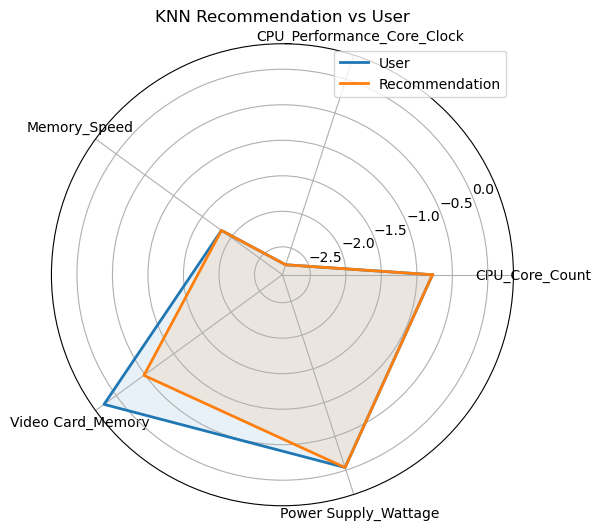

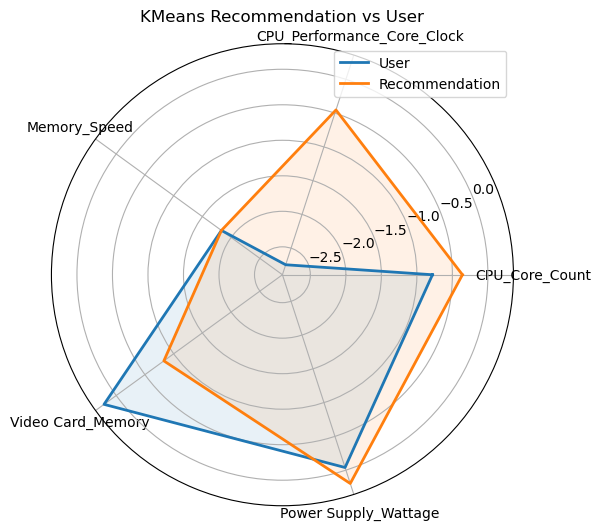

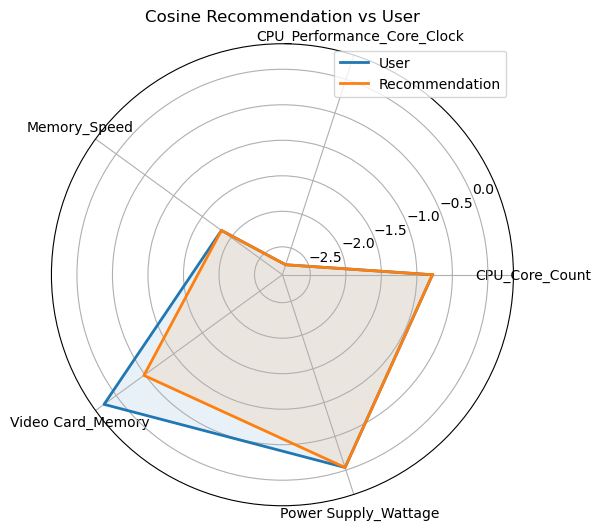

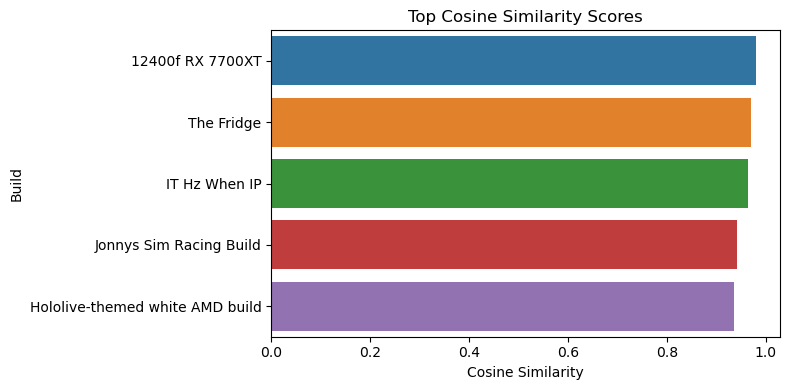

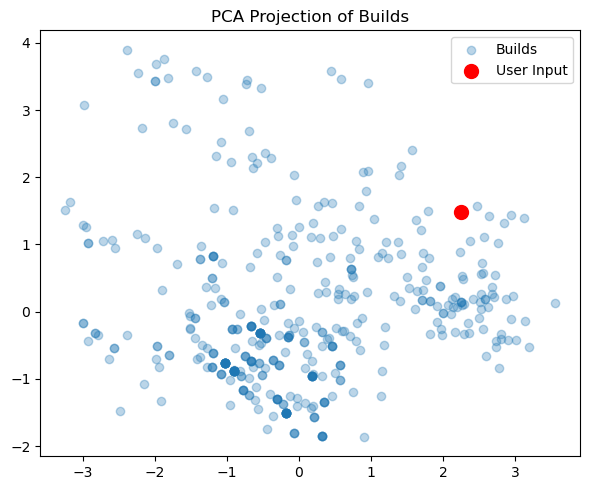


📐 Distances from User Input:
KNN: Avg Cosine Distance = 0.0455
KMeans: Avg Cosine Distance = 0.2416
Cosine: Avg Cosine Distance = 0.0421

🔁 Model Agreement: 1 overlapping recommendations across all models


In [20]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Load models and data
scaler = joblib.load('models/scaler.pkl')
build_table = pd.read_csv("models/build_table.csv")
feature_cols = [
    'CPU_Core_Count', 'CPU_Performance_Core_Clock',
    'Memory_Speed', 'Video Card_Memory', 'Power Supply_Wattage'
]
X = build_table[feature_cols].astype(float)
X_scaled = scaler.transform(X)

# User input
user_input = {
    'CPU_Core_Count': 6,
    'CPU_Performance_Core_Clock': 2500          ,
    'Memory_Speed': 3200,
    'Video Card_Memory': 16,
    'Power Supply_Wattage': 650
}
user_vector = np.array([list(user_input.values())]).astype(float)
user_df = pd.DataFrame(user_vector, columns=feature_cols)
user_scaled = scaler.transform(user_df)


# --- 1. KNN ---
knn_model = joblib.load('models/knn_model.pkl')
_, indices_knn = knn_model.kneighbors(user_scaled)
recs_knn = build_table.iloc[indices_knn[0]]

# --- 2. KMeans ---
kmeans_model = joblib.load('models/kmeans_model.pkl')
cluster = kmeans_model.predict(user_scaled)[0]
recs_kmeans = build_table[kmeans_model.labels_ == cluster].head(5)

# --- 3. Cosine Similarity ---
cosine_sim_matrix = cosine_similarity(user_scaled, X_scaled)
top_indices = np.argsort(cosine_sim_matrix[0])[::-1][:5]
recs_cosine = build_table.iloc[top_indices]
cosine_scores = cosine_sim_matrix[0][top_indices]

# Print results
print("\n🔹 KNN Recommendations:")
print(recs_knn[['Build Title'] + list(user_input.keys())])
print("\n🔹 KMeans Recommendations:")
print(recs_kmeans[['Build Title'] + list(user_input.keys())])
print("\n🔹 Cosine Similarity Recommendations:")
print(recs_cosine[['Build Title'] + list(user_input.keys())])

# --------------------------------------
# 📊 CHARTS
# --------------------------------------

# 🛡️ Radar Chart: User vs Top Recommendation from each model
def plot_radar(user_vals, build_vals, labels, title):
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    user_vals += user_vals[:1]
    build_vals += build_vals[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, user_vals, label='User', linewidth=2)
    ax.plot(angles, build_vals, label='Recommendation', linewidth=2)
    ax.fill(angles, user_vals, alpha=0.1)
    ax.fill(angles, build_vals, alpha=0.1)
    ax.set_title(title)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.legend()
    plt.show()

# Normalize values for radar
user_vals = user_scaled[0].tolist()

print("\n📊 Radar Charts:")
for label, rec in zip(
    ['KNN', 'KMeans', 'Cosine'],
    [recs_knn, recs_kmeans, recs_cosine]
):
    build_vals = scaler.transform(
        rec[feature_cols].astype(float).iloc[0:1]
    )[0].tolist()
    plot_radar(user_vals.copy(), build_vals.copy(), feature_cols, f"{label} Recommendation vs User")

# 📈 Cosine Similarity Bar Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=cosine_scores, y=recs_cosine['Build Title'])
plt.title('Top Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Build')
plt.tight_layout()
plt.show()

# 📉 Optional: PCA Projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
user_pca = pca.transform(user_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, label="Builds")
plt.scatter(user_pca[0, 0], user_pca[0, 1], color='red', label='User Input', s=100)
plt.title("PCA Projection of Builds")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------
# 📏 ACCURACY-LIKE METRICS
# --------------------------------------

def cosine_distance(a, b):
    return 1 - cosine_similarity(a, b)[0][0]

print("\n📐 Distances from User Input:")
for name, recs in zip(['KNN', 'KMeans', 'Cosine'], [recs_knn, recs_kmeans, recs_cosine]):
    dists = [
        cosine_distance(user_scaled, scaler.transform(pd.DataFrame([r[feature_cols]], columns=feature_cols))
)
        for _, r in recs.iterrows()
    ]
    print(f"{name}: Avg Cosine Distance = {np.mean(dists):.4f}")

# Agreement metric
knn_titles = set(recs_knn['Build Title'])
kmeans_titles = set(recs_kmeans['Build Title'])
cosine_titles = set(recs_cosine['Build Title'])

intersection = knn_titles & kmeans_titles & cosine_titles
print(f"\n🔁 Model Agreement: {len(intersection)} overlapping recommendations across all models")


In [24]:
# Define and fit the k-NN model
knn = make_pipeline(StandardScaler(), NearestNeighbors(n_neighbors=5, metric='euclidean'))
knn.fit(X)  # X is the feature matrix from build_table

# Save models
joblib.dump(knn, os.path.join('models', 'knn_model.pkl'))


# Save build_table
build_table.to_pickle(os.path.join('models', 'build_table.pkl'))
print("Saved build_table to 'models/build_table.pkl'")

Saved build_table to 'models/build_table.pkl'


In [25]:
knn = make_pipeline(StandardScaler(), NearestNeighbors(n_neighbors=5, metric='euclidean'))
X = build_table[feature_columns].values  # Should use all 18 features
knn.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nearestneighbors', NearestNeighbors(metric='euclidean'))])